In [1]:
import scipy
import fitsio
import smatch
import proplot as pplt
import matplotlib.pyplot as plt
import numpy as np
import hpgeom
import numba
import tqdm

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
_ed = fitsio.read("des_exposure_data.fits")

In [3]:
_ed = np.sort(_ed, order="mjd_obs")

In [4]:
_ed.shape

(100802,)

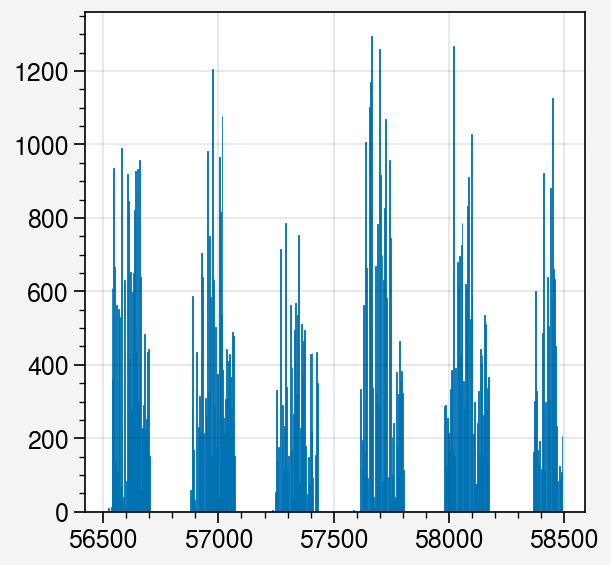

In [5]:
fig, axs = pplt.subplots()

axs.hist(_ed["mjd_obs"], bins=500);

In [ ]:
from silly_cal.models import nights_with_mirror

nside = 1024
nside = 512

bmsk = (_ed["band"] == "r") | (_ed["band"] == "r")
fd = nights_with_mirror.gen_fake_data(
    # edata=_ed[bmsk],
    edata=_ed[(_ed["mjd_obs"] < 57200) & bmsk],
    # edata=_ed[(_ed["mjd_obs"] > 57900) & bmsk],
    # edata=_ed[(_ed["mjd_obs"] > 57500) & (_ed["mjd_obs"] < 57900) & (_ed["band"] == "r")],
    nside=nside,
    seed=None,
    target_nstar=20e6,
    period=365,
)

In [ ]:
fig, axs = pplt.subplots(figsize=(8, 2))

axs.plot(fd["data"]["night"], fd["data"]["true_zp"], ".", markersize=2)
yv = fd["data"]["true_zp_night"][fd["data"]["inv_unight"]]
axs.plot(fd["data"]["night"], yv, ",", color="r")

# axs.format(ylim=(-1.5, 0.2), xlim=(0, 50))

## Optimize the Loss

In [ ]:
# from silly_cal.optimizers import run_amsgrad, run_laprop

# from functools import partial

# pars = nights_with_mirror.gen_guess(fd["opt_kwargs"], eps=1e-2)
# grad = np.zeros_like(pars)
# nt = numba.get_num_threads()
# tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

# def ofun(pars):
#     return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])

# ores = run_laprop(ofun, pars, 1e-3, 10000)
# ores

In [ ]:
from scipy.optimize import minimize
from functools import partial

pars = nights_with_mirror.gen_guess(fd["opt_kwargs"], eps=1e-2)
grad = np.zeros_like(pars)
nt = numba.get_num_threads()
tgrads = np.zeros((nt, grad.shape[0]), dtype=np.float64)

def ofun(pars):
    return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[0]

def ofun_jac(pars):
    return nights_with_mirror.value_and_grad(pars, grad, tgrads, **fd["opt_kwargs"])[1].copy()

res = minimize(
    ofun, pars, method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10),
)
res = minimize(
    ofun, res["x"], method="L-BFGS-B", jac=ofun_jac, options=dict(disp=10),
)
res

In [ ]:
fdd = fd["data"]

In [ ]:
fdd["true_tel_eff"], res["x"][0:fdd["true_tel_eff"].shape[0]]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import healsparse as hsp

import skyproj

In [ ]:
hmap = hsp.HealSparseMap.make_empty(32, nside, np.float64)

In [ ]:
est_star = res["x"][fd["opt_kwargs"]["nyear"] + fd["opt_kwargs"]["nnight"]+fd["opt_kwargs"]["nexp"]:]

dstar = est_star - fdd["true_star"]

hmap.update_values_pix(fdd["true_star_nest_ind"], dstar)

In [ ]:
from mattspy.stats import mad

np.mean(dstar), mad(dstar)

In [ ]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12), squeeze=False)

mn_map = hmap.degrade(64, reduction="mean")
sd_map = hmap.degrade(64, reduction="std")
mean_sd = np.median(sd_map.get_values_pix(sd_map.valid_pixels))

sp = skyproj.McBrydeSkyproj(ax=axs[0, 0])
sp.draw_hspmap(mn_map * 1e3, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag$ [mmag]")

sp = skyproj.McBrydeSkyproj(ax=axs[0, 1])
sp.draw_hspmap(mn_map / mean_sd, cmap="rocket")
sp.draw_inset_colorbar(label="$\Delta mag/RMS$")

sp = skyproj.McBrydeSkyproj(ax=axs[1, 0])
sp.draw_hspmap(sd_map / 1e-3, cmap="rocket")
sp.draw_inset_colorbar(label="RMS [mmag]")

axs[1, 1].set_visible(False)